# Drive time analysis for opioid epidemic

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Drive-time-analysis-for-opioid-epidemic" data-toc-modified-id="Drive-time-analysis-for-opioid-epidemic-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Drive time analysis for opioid epidemic</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Problem" data-toc-modified-id="Problem-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Problem</a></span></li><li><span><a href="#Data-Driven-Approach" data-toc-modified-id="Data-Driven-Approach-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Data Driven Approach</a></span></li><li><span><a href="#Steps-of-analysis" data-toc-modified-id="Steps-of-analysis-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Steps of analysis</a></span></li><li><span><a href="#1.-Reading-in-clinics-and-Oakland-county-census-block-group-(CBG)-boundaries" data-toc-modified-id="1.-Reading-in-clinics-and-Oakland-county-census-block-group-(CBG)-boundaries-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>1. Reading in clinics and Oakland county census block group (CBG) boundaries</a></span></li><li><span><a href="#2.-Drive-time-analysis" data-toc-modified-id="2.-Drive-time-analysis-1.0.5"><span class="toc-item-num">1.0.5&nbsp;&nbsp;</span>2. Drive time analysis</a></span><ul class="toc-item"><li><span><a href="#Service-area-generation-for-the-visible-[5]-minutes-layer" data-toc-modified-id="Service-area-generation-for-the-visible-[5]-minutes-layer-1.0.5.1"><span class="toc-item-num">1.0.5.1&nbsp;&nbsp;</span>Service area generation for the visible [5] minutes layer</a></span></li></ul></li><li><span><a href="#3.-Spatially-join-the-drive_times_all_layer-layer-with-oakland_cbg-layer-to-obtain-drive-times-for-each-census-block-group" data-toc-modified-id="3.-Spatially-join-the-drive_times_all_layer-layer-with-oakland_cbg-layer-to-obtain-drive-times-for-each-census-block-group-1.0.6"><span class="toc-item-num">1.0.6&nbsp;&nbsp;</span>3. Spatially join the <code>drive_times_all_layer</code> layer with <code>oakland_cbg</code> layer to obtain drive times for each census block group</a></span></li><li><span><a href="#4.-Enrich-census-block-groups-with-suitable-data" data-toc-modified-id="4.-Enrich-census-block-groups-with-suitable-data-1.0.7"><span class="toc-item-num">1.0.7&nbsp;&nbsp;</span>4. Enrich census block groups with suitable data</a></span></li><li><span><a href="#5.-Visualize-results" data-toc-modified-id="5.-Visualize-results-1.0.8"><span class="toc-item-num">1.0.8&nbsp;&nbsp;</span>5. Visualize results</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.0.9"><span class="toc-item-num">1.0.9&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li></ul></li></ul></div>

This notebook performs drive time analysis for clinics of opioid epidemic treatment and/or prevention centers in the county of Oakland, Michigan. 

### Problem

Drug overdoses are a leading cause of injury death in the United States, resulting in approximately __52,000 deaths in 2015. In the same year, the overdose death rate in non metropolitan areas of the country (17 per 100,000) surpassed the metropolitan area rate (16.2 per 100,000), which historically wasn't the case.__

While metro areas have more people, and consequently, a greater incidence of drug use and overdose, the one stark disadvantage in the non metro areas is the comparatively limited access to opioid epidemic prevention/treatment facilities and transit.

### Data Driven Approach

Here, we demonstrate an analysis of how several parts of Oakland county in Michigan are accessible from their opioid epidemic prevention and/or treatment centers within 5, 10, 15, 20 and 25 minutes of drive time. The areas of the county identified within those time bound service areas are then enriched with factors such as

>    Health insurance spending
>
>    Number of people with a Bachelor's Degree
>
>    Total Population in 2017

This provides a __better understanding of the population served or under-served by these treatment facilities and the plausible contributing factors.__

### Steps of analysis

1. Get data for clinics and census block groups boundary (CBG) in Oakland County
2. Generate areas served based on time taken to drive to the clinics
3. Spatially join the service areas generated with the CBG to obtain drive time to closest clinic for each CBG.
4. Enrich each CBG with additional data to estimate influencing factors.
5. Visualize results

Let's get started by first importing necessary modules and connecting to our GIS

In [1]:
#Import necessary packages
from arcgis.gis import GIS
from datetime import datetime
from arcgis.features import FeatureLayer

from arcgis.features.use_proximity import create_drive_time_areas
from arcgis.features.analysis import join_features
from arcgis.features.enrich_data import enrich_layer

In [2]:
# Connect to GIS
gis = GIS(profile="your_online_profile") 

### 1. Reading in clinics and Oakland county census block group (CBG) boundaries

In [3]:
# Layer URLS for the Opioid Epidemic Clinics in Oakland County and Census Block Groups of Oakland County
clinic_url = 'https://services8.arcgis.com/TWfU0bgvgUkCgHLa/arcgis/rest/services/Oakland_County_Licensed_Program_Listings/FeatureServer/0/'
oakland_cbg = 'https://services.arcgis.com/bkrWlSKcjUDFDtgw/arcgis/rest/services/Oakland_2010_census_bg/FeatureServer/0/'

# create feature layers
clinic_layer = FeatureLayer(clinic_url)
oakland_layer = FeatureLayer(oakland_cbg)

In [4]:
# Query all clinics and census block groups as FeatureSets
clinic_features = clinic_layer.query()
print('Total number of rows in the clinic dataset: ' + str(len(clinic_features.features)))

oakland_features = oakland_layer.query()
print('Total number of rows in the oakland dataset: ' + str(len(oakland_features.features)))

Total number of rows in the clinic dataset: 122
Total number of rows in the oakland dataset: 934


We notice that Oakland County, MI has __122 clinics__ and __934 Census Block Groups (CBG)__

In [5]:
# Convert to SpatialDataFrames
clinic = clinic_features.sdf
clinic.head()

,Name,Contact_Name,Address,City,State,Zip,Phone_Number,Key_,Type,LicenseNumber,FID,SHAPE
0,SUNRISE TREATMENT CENTER,"Dr. Carmen Cardona, Program Director","989 University Dr., Ste. 108",Pontiac,MI,48342,248-481-2531,Case Management; Integrated Treatment; Outpa...,Treatment,# SA0631356,1,"{""x"": -9268869.4566, ""y"": 5259550.238600001, ""..."
1,"EIP, INC. (Education Intervention Programs)","Stacy Gutowsky, Program Director","4120 W. Maple Rd., Ste. 201",Bloomfield Hills,MI,48301,248-693-0336,Alcohol Hwy Safety Education; Community Change...,Prevention,# SA0631330,2,"{""x"": -9271532.8795, ""y"": 5242995.079599999, ""..."
2,"THE ART OF HOPE, HEALING & HAPPINESS","Karen Fraiberg, Program Director",3283 Bloomfield Park Dr,West Bloomfield,MI,48323,248-229-4717,"Case Management; Community Change, Alternative...",Both,# SA0631364,3,"{""x"": -9278211.6833, ""y"": 5246510.740000002, ""..."
3,"RECOVERY CONSULTANTS, INC.","Kathy Smaller, Program Director",2710 W. 12 Mile Rd.,Berkley,MI,48072,248-543-1090,Case Management; Early Intervention; Integrate...,Treatment,# SA0631165,4,"{""x"": -9260261.7618, ""y"": 5236694.745800003, ""..."
4,"RECOVERY CONSULTANTS, INC.","Kathy Smaller, Program Director","3139 W. Huron St. Waterford, MI 48328",Waterford,MI,48328,248-738-8400,Case Management; Early Intervention; Integrate...,Treatment,# SA0631166,5,"{""x"": -9278492.0901, ""y"": 5256952.089100003, ""..."


In [6]:
oakland = oakland_features.sdf
oakland.head()

,FID,NAME,LABEL,TYPE,LINK,CNTY_CODE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,Shape__Area,Shape__Length,SHAPE
0,1,1200001,BG 1,BG,1251200001,125,16.494592,6.368568,4075.858559,14a,portrait,lower,30734809.480469,22611.540412,"{""rings"": [[[-9250818.94177608, 5289778.006450..."
1,2,1203001,BG 1,BG,1251203001,125,35.604171,13.746784,8797.887541,14a,portrait,lower,66331290.691406,35417.658796,"{""rings"": [[[-9264026.53064651, 5290079.339554..."
2,3,1210001,BG 1,BG,1251210001,125,27.0899,10.459421,6693.987915,14a,landscape,lower,50477874.964844,29332.713639,"{""rings"": [[[-9270503.93750677, 5288614.193867..."
3,4,1214001,BG 1,BG,1251214001,125,21.852249,8.437162,5399.750207,14a,portrait,lower,40705739.753906,29772.396132,"{""rings"": [[[-9269511.1796278, 5286236.4642479..."
4,5,1222002,BG 2,BG,1251222002,125,15.05158,5.811421,3719.286317,14a,portrait,lower,28044483.894531,23245.466116,"{""rings"": [[[-9281344.03654134, 5290365.890503..."



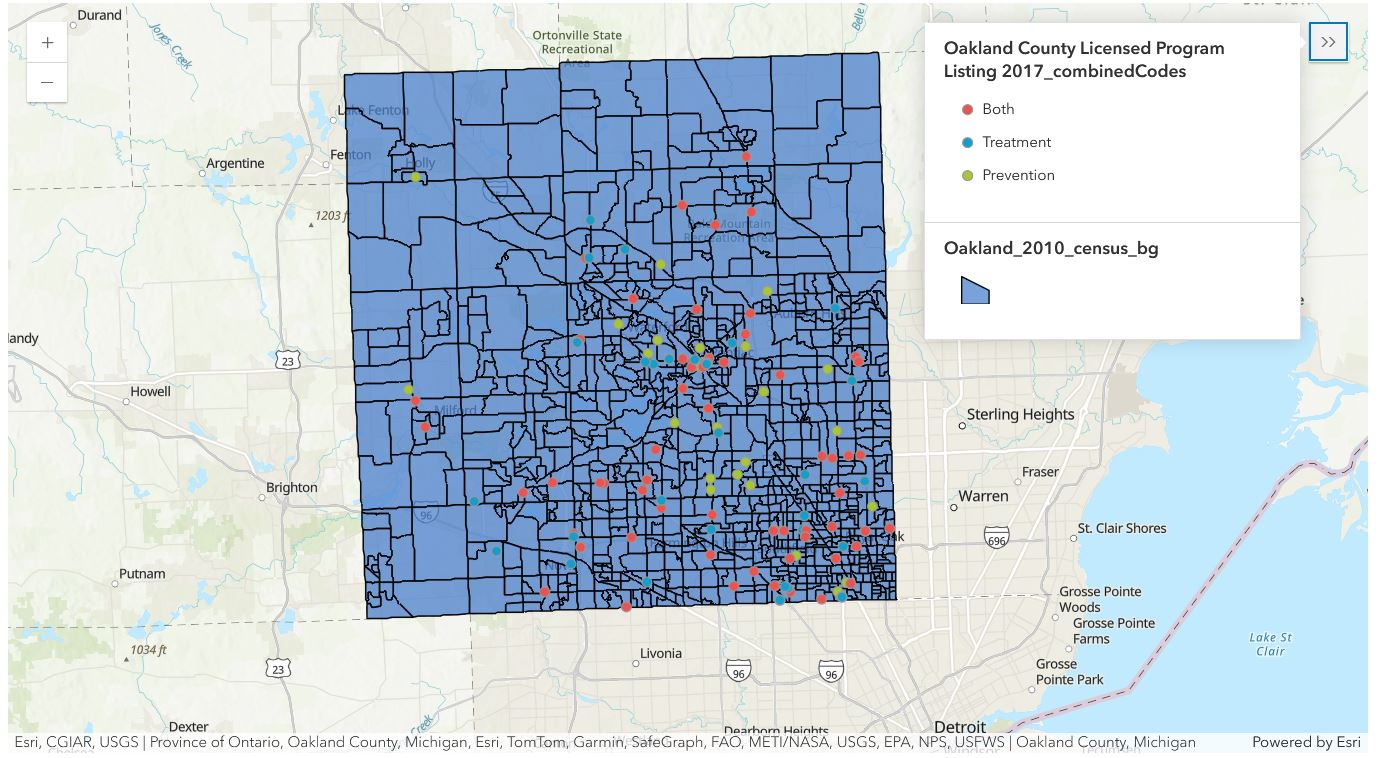

In [14]:
m1 = gis.map('Oakland, Michigan')
m1

In [9]:
m1.basemap.basemap = 'topo-vector'

In [10]:
m1.content.add(oakland_layer)
m1.content.add(clinic_layer)

In [11]:
m1.zoom_to_layer(clinic_layer)

In [12]:
m1.legend.enabled = True

### 2. Drive time analysis

Service areas around the clinics need to be generated twice for two different sets of drive time inputs:

> 1. __`[5, 10, 15, 20, 25]`__ that is needed to get the drive time required from each CBG to the closest clinic. While adding more/less intervals is certainly an option, the choice of time intervals here is meant to span the range (closest-to-farthest clinic) as well as assume a range of safety, i.e. time within which a person can be driven/drive to a clinic to avoid delays.
>
> 2. __`[5]`__ that is needed purely for visualization purposes (as seen towards the end of the notebook). Feel free to modify this function parameter based on how you would like to visualize the map.

Service area generation for the [5, 10, 15, 20, 25] minutes layer

In [ ]:
# Generate service areas
result = create_drive_time_areas(input_layer = clinic_layer, 
                                 travel_mode = 'Driving Time',
                                 break_values = [5, 10, 15, 20, 25], 
                                 output_name = "DriveTimeToClinics_All_2"+ str(datetime.now().microsecond), 
                                 overlap_policy = 'Dissolve')

In [16]:
# Check type of result
type(result)

arcgis.gis.Item

In [17]:
# Share results for public consumption
result.sharing.sharing_level = 'EVERYONE'
result.sharing.shared_with

{'groups': [], 'level': <SharingLevel.EVERYONE: 'EVERYONE'>}

In [18]:
# Convert it to a FeatureSet
drive_times_all_layer = result.layers[0]
driveAll_features = drive_times_all_layer.query()
print('Total number of rows in the service area (upto 25 mins) dataset: '+ str(len(driveAll_features.features)))

Total number of rows in the service area (upto 25 mins) dataset: 5


This implies that only 5 clinics in this county can be driven to within 5 minutes.

In [19]:
# Get results as a SpatialDataFrame
driveAll = driveAll_features.sdf
driveAll.head()

,OBJECTID,Name,FromBreak,ToBreak,FacilityOID,AnalysisArea,SHAPE
0,1,20 - 25,20.0,25.0,<NA>,1324.839701,"{""rings"": [[[-9328831.7041, 5279863.445], [-93..."
1,2,15 - 20,15.0,20.0,<NA>,1201.15137,"{""rings"": [[[-9284931.905, 5211469.241], [-928..."
2,3,10 - 15,10.0,15.0,<NA>,1130.09381,"{""rings"": [[[-9291856.8733, 5223753.8369], [-9..."
3,4,5 - 10,5.0,10.0,<NA>,1047.34542,"{""rings"": [[[-9273081.9592, 5293568.0208], [-9..."
4,5,0 - 5,0.0,5.0,<NA>,796.467658,"{""rings"": [[[-9277056.9411, 5277308.8349], [-9..."



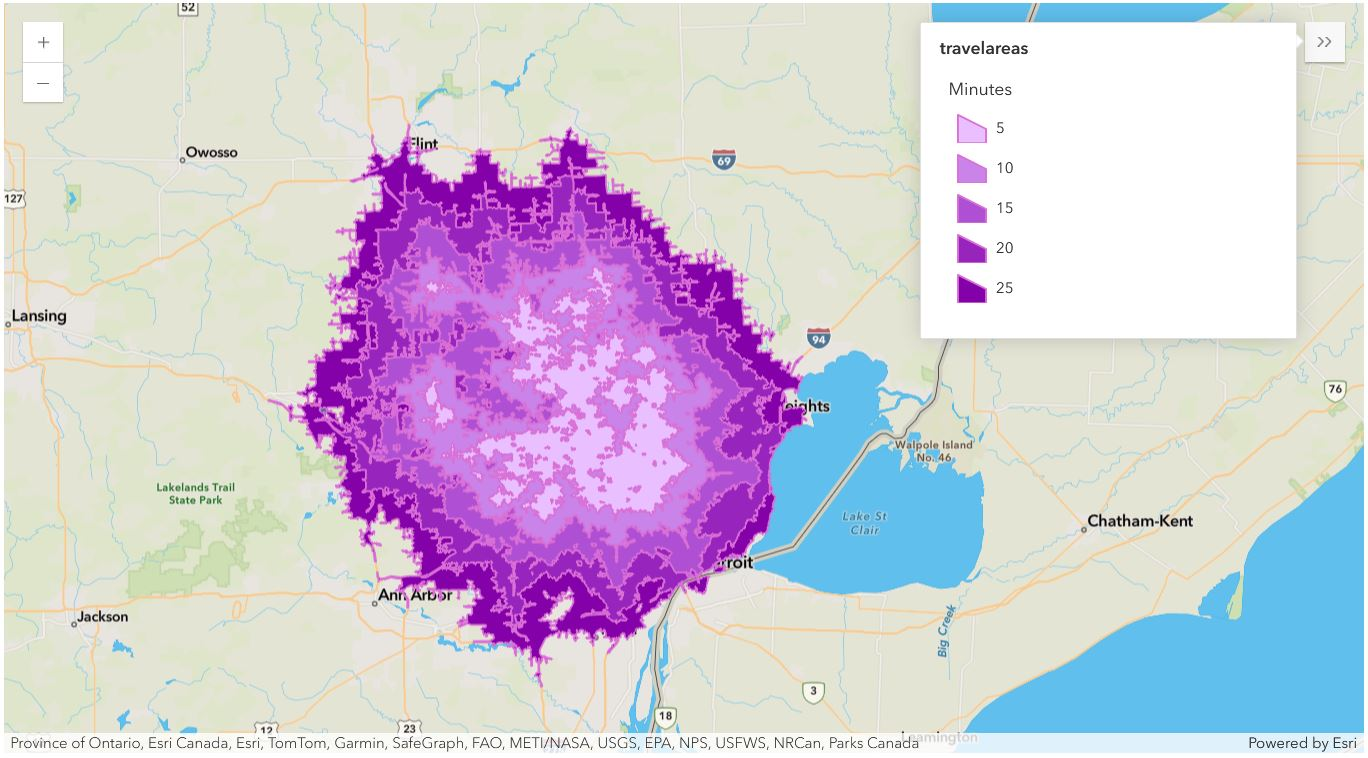

In [24]:
m_drive_times = gis.map('Oakland, Michigan')
m_drive_times

In [21]:
m_drive_times.content.add(result.layers[0])

In [22]:
m_drive_times.zoom_to_layer(result.layers[0])

In [23]:
m_drive_times.legend.enabled = True

#### Service area generation for the visible [5] minutes layer

In [ ]:
# Generate service areas
visible_result = create_drive_time_areas(input_layer = clinic_layer, 
                                         break_values = [5], 
                                         travel_mode = 'Driving Time',
                                         output_name = "DriveTimeToClinics_5mins"+str(datetime.now().microsecond), 
                                         overlap_policy = 'Dissolve')

In [27]:
# Grant 'visible_result' public access
visible_result.sharing.sharing_level = "EVERYONE"
visible_result.sharing.shared_with

{'groups': [], 'level': <SharingLevel.EVERYONE: 'EVERYONE'>}

### 3. Spatially join the `drive_times_all_layer` layer with `oakland_cbg` layer to obtain drive times for each census block group

In [ ]:
# Perform spatial join between CBG layer and the service areas created for all time durations
cbg_with_driveTime = join_features(target_layer = oakland_cbg, 
                                   join_layer = drive_times_all_layer, 
                                   spatial_relationship = 'Intersects', 
                                   output_name = 'Oakland_CBG_allDriveTimes'+str(datetime.now().microsecond))

In [29]:
# Grant 'cbg_with_driveTime' public access
cbg_with_driveTime.sharing.sharing_level = "EVERYONE"
cbg_with_driveTime.sharing.shared_with

{'groups': [], 'level': <SharingLevel.EVERYONE: 'EVERYONE'>}

In [30]:
# Converting it to a FeatureSet
drive_times_cbg = cbg_with_driveTime.layers[0]
drive_times_features = drive_times_cbg.query()
print('Total number of rows in the drive time (upto 25 mins) dataset: '+ str(len(drive_times_features.features)))

Total number of rows in the drive time (upto 25 mins) dataset: 934


This implies that the farthest clinic in the county is within a 25 minute drive time window

In [31]:
# Convert it to a SpatialDataFrame
drive_time_cbg_df = drive_times_features.sdf
drive_time_cbg_df.head()

,OBJECTID,Join_Count,TARGET_FID,NAME,LABEL,TYPE,LINK,CNTY_CODE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,Name_1,FromBreak,ToBreak,FacilityOID,AnalysisArea,SHAPE
0,1,2,1,1200001,BG 1,BG,1251200001,125,16.494592,6.368568,4075.858559,14a,portrait,lower,20 - 25,20.0,25.0,<NA>,1324.839701,"{""rings"": [[[-9250818.9418, 5289778.0065], [-9..."
1,2,4,2,1203001,BG 1,BG,1251203001,125,35.604171,13.746784,8797.887541,14a,portrait,lower,20 - 25,20.0,25.0,<NA>,1324.839701,"{""rings"": [[[-9264026.5306, 5290079.3396], [-9..."
2,3,3,3,1210001,BG 1,BG,1251210001,125,27.0899,10.459421,6693.987915,14a,landscape,lower,15 - 20,15.0,20.0,<NA>,1201.15137,"{""rings"": [[[-9270503.9375, 5288614.1939], [-9..."
3,4,3,4,1214001,BG 1,BG,1251214001,125,21.852249,8.437162,5399.750207,14a,portrait,lower,15 - 20,15.0,20.0,<NA>,1201.15137,"{""rings"": [[[-9269511.1796, 5286236.4642], [-9..."
4,5,3,5,1222002,BG 2,BG,1251222002,125,15.05158,5.811421,3719.286317,14a,portrait,lower,15 - 20,15.0,20.0,<NA>,1201.15137,"{""rings"": [[[-9281344.0365, 5290365.8905], [-9..."


### 4. Enrich census block groups with suitable data

The 3 geo-enrichment factors that we will be including in this study are:

> **Note:** Organizations should review the [data attributions](https://www.esri.com/en-us/legal/terms/data-attributions) and [Master Agreement](https://www.esri.com/content/dam/esrisites/en-us/media/legal/ma-full/ma-full.pdf) to make sure they are in compliance when geoenriching data and making it available to other systems.

> 1. 2017 Total Population (Analysis Variable - TOTPOP_CY)
> 2. 2017 Health Insurance (Analysis Variable - X8002_X)
> 3. 2017 Education : Bachelor's Degree (Analysis Variable - BACHDEG_CY)

In [ ]:
# Perform data enrichment
enriched_drive_time_cbg = enrich_layer(drive_times_cbg, 
                                       analysis_variables=['TOTPOP_CY', 'X8002_X', 'BACHDEG_CY'], 
                                       output_name="Enriched_DriveTime_CBG"+str(datetime.now().microsecond))

In [33]:
# Check type of 'enriched_drive_time_cbg'
type(enriched_drive_time_cbg)

arcgis.gis.Item

In [34]:
# Grant 'enriched_drive_time_cbg' public access
enriched_drive_time_cbg.sharing.sharing_level = "EVERYONE"
enriched_drive_time_cbg.sharing.shared_with

{'groups': [], 'level': <SharingLevel.EVERYONE: 'EVERYONE'>}

In [35]:
# Convert it to a Feature Set
enriched_driveTimes_layer = enriched_drive_time_cbg.layers[0]
enriched_driveTimes_features = enriched_driveTimes_layer.query()
print('Total number of rows in the drive time (upto 25 mins) dataset: '+ str(len(enriched_driveTimes_features.features)))

Total number of rows in the drive time (upto 25 mins) dataset: 934


In [36]:
# Convert it to a SpatialDataFrame
enriched_df = enriched_driveTimes_features.sdf
enriched_df.head()

,OBJECTID,Join_Count,TARGET_FID,NAME,LABEL,TYPE,LINK,CNTY_CODE,SQKM,SQMILES,...,sourceCountry,ENRICH_FID,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,TOTPOP_CY,X8002_X,BACHDEG_CY,SHAPE
0,1,2,1,1200001,BG 1,BG,1251200001,125,16.494592,6.368568,...,US,1,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,909.0,2281088.0,103.0,"{""rings"": [[[-9250818.9418, 5289778.0065], [-9..."
1,2,4,2,1203001,BG 1,BG,1251203001,125,35.604171,13.746784,...,US,2,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,1580.0,3960909.0,349.0,"{""rings"": [[[-9264026.5306, 5290079.3396], [-9..."
2,3,3,3,1210001,BG 1,BG,1251210001,125,27.0899,10.459421,...,US,3,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,642.0,1598570.0,226.0,"{""rings"": [[[-9270503.9375, 5288614.1939], [-9..."
3,4,3,4,1214001,BG 1,BG,1251214001,125,21.852249,8.437162,...,US,4,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,4799.0,12224037.0,987.0,"{""rings"": [[[-9269511.1796, 5286236.4642], [-9..."
4,5,3,5,1222002,BG 2,BG,1251222002,125,15.05158,5.811421,...,US,5,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,1624.0,3815530.0,239.0,"{""rings"": [[[-9281344.0365, 5290365.8905], [-9..."


In [37]:
# Print column names for ease of use during visualization
enriched_df.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'NAME', 'LABEL', 'TYPE', 'LINK',
       'CNTY_CODE', 'SQKM', 'SQMILES', 'ACRES', 'VER', 'LAYOUT', 'PENINSULA',
       'Name_1', 'FromBreak', 'ToBreak', 'FacilityOID', 'AnalysisArea', 'ID',
       'sourceCountry', 'ENRICH_FID', 'aggregationMethod',
       'populationToPolygonSizeRating', 'apportionmentConfidence', 'HasData',
       'TOTPOP_CY', 'X8002_X', 'BACHDEG_CY', 'SHAPE'],
      dtype='object')

### 5. Visualize results


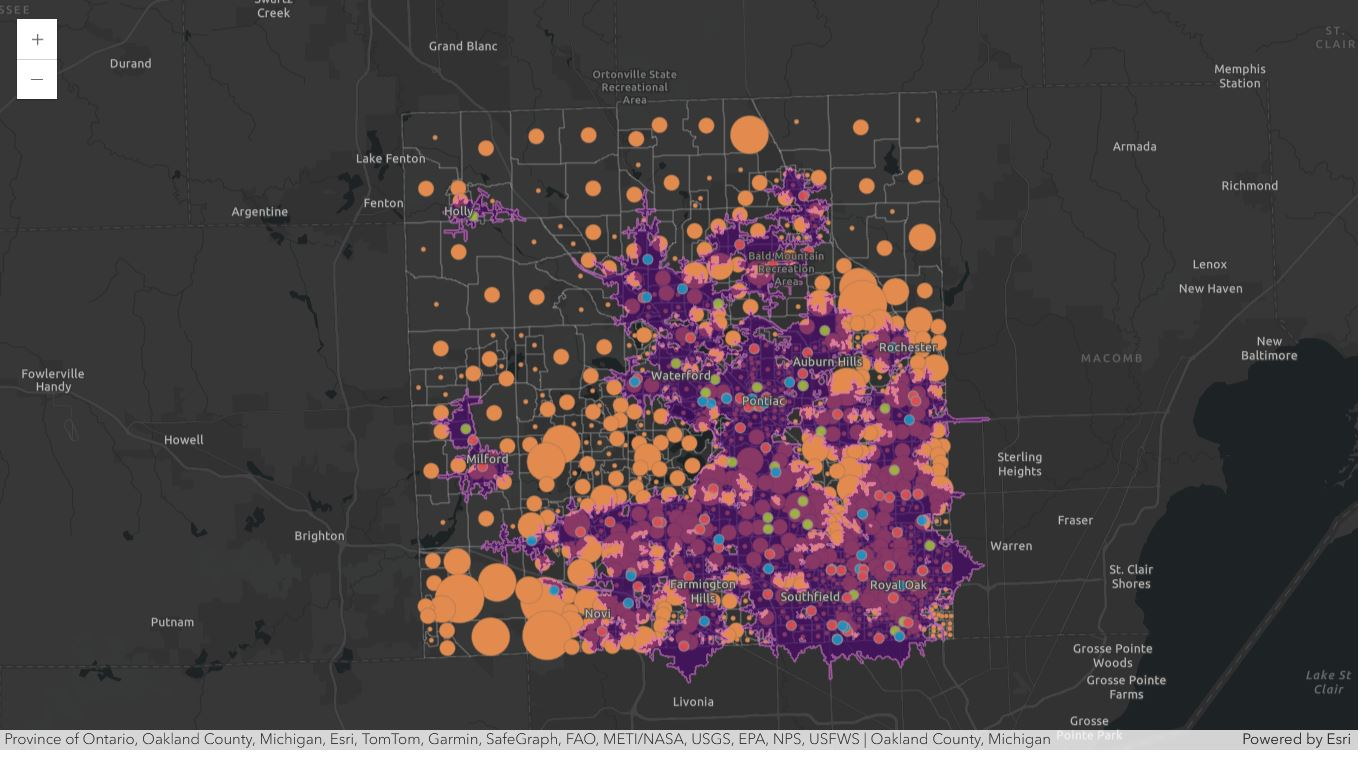

In [2]:
# Create map of Oakland county
map1 = gis.map('Oakland, Michigan')
map1.basemap.basemap = 'arcgis-dark-gray'
map1

In [39]:
map1.content.add(enriched_driveTimes_layer)
#Use smart mapping to render size based classes
sm_manager = map1.content.renderer(0).smart_mapping()
sm_manager.class_breaks_renderer(break_type="size", field="X8002_X", num_classes=5)

In [40]:
#Visualize drive time areas
map1.content.add(visible_result.layers[0], options = {'opacity':0.6})

In [41]:
map1.content.add(clinic_layer, options = {'opacity':0.85})

In [44]:
map1.zoom_to_layer(enriched_driveTimes_layer)

Similar maps can be generated for the following variables too
> 1. Travel Time (`ToBreak`)
> 2. Population (`TOTPOP_CY`)
> 3. Citizens with Bachelor's Degree (`BACHDEG_CY`)

### Conclusion

As we can see from the map, clinics are concentrated in a certain part of the county. A few counties have relatively larger population, as compared to their health care spending and population count with Bachelor's degrees and don't have clinics very close by (drime time greater than 10 mins). This subtly hints at disparity in location of clinics with population/affluence level of the county. 

This analysis also sets stage for bringing in data about patients of this epidemic, to do a socio-economic study of this epidemic.